# Performance comparison

In [1]:
import cudf
import pandas as pd
import numpy as np
import time
from io import BytesIO
import os
import timeit

In [2]:
np.random.seed(0)

In [3]:
pdf = pd.DataFrame({
    "numbers": np.random.randint(-1000, 1000, 30_000_0000, dtype='int64'),
    "business": np.random.choice(["McD", "Buckees", "Walmart", "Costco"], size=30_000_0000)
})

In [4]:
pdf

,numbers,business
0,-316,Costco
1,-441,Costco
2,653,Buckees
3,216,Buckees
4,-165,Walmart
...,...,...
299999995,-395,Walmart
299999996,-653,Buckees
299999997,364,Buckees
299999998,159,Buckees


In [5]:
gdf = cudf.from_pandas(pdf)

In [6]:
gdf

,numbers,business
0,-316,Costco
1,-441,Costco
2,653,Buckees
3,216,Buckees
4,-165,Walmart
...,...,...
299999995,-395,Walmart
299999996,-653,Buckees
299999997,364,Buckees
299999998,159,Buckees


In [7]:
pandas_pq = BytesIO()

In [8]:
pandas_to_parquet = timeit.timeit(lambda : pdf.to_parquet(BytesIO()), number=30)

In [9]:
cudf_pq = BytesIO()

In [10]:
cudf_to_parquet = timeit.timeit(lambda : gdf.to_parquet(BytesIO()), number=30)

In [11]:
pdf.to_parquet(pandas_pq)
gdf.to_parquet(cudf_pq)

In [12]:
os.system("/sbin/sysctl vm.drop_caches=3")
pandas_read_parquet = timeit.timeit(lambda : pd.read_parquet(pandas_pq), number=30)

sysctl: setting key "vm.drop_caches", ignoring: Read-only file system


In [13]:
os.system("/sbin/sysctl vm.drop_caches=3")
cudf_read_parquet = timeit.timeit(lambda : cudf.read_parquet(cudf_pq), number=30)

sysctl: setting key "vm.drop_caches", ignoring: Read-only file system


In [14]:
pdf = pdf.head(10_000_0000)
gdf = gdf.head(10_000_0000)

In [15]:
def to_csv_bench(df):
    file_obj = BytesIO()
    df.to_csv(file_obj)

In [16]:
pandas_to_csv = timeit.timeit(lambda : to_csv_bench(pdf), number=30)

In [17]:
cudf_to_csv = timeit.timeit(lambda : to_csv_bench(gdf), number=30)

In [18]:
pandas_csv = BytesIO()
cudf_csv = BytesIO()
pdf.to_csv(pandas_csv)
gdf.to_csv(cudf_csv)

In [19]:
def read_csv_bench(pkg, file_obj):
    file_obj.seek(0)
    pkg.read_csv(file_obj)

In [20]:
os.system("/sbin/sysctl vm.drop_caches=3")
pandas_read_csv = timeit.timeit(lambda : read_csv_bench(pd, pandas_csv), number=30)

sysctl: setting key "vm.drop_caches", ignoring: Read-only file system


In [21]:
os.system("/sbin/sysctl vm.drop_caches=3")
cudf_read_csv = timeit.timeit(lambda : read_csv_bench(cudf, cudf_csv), number=30)

sysctl: setting key "vm.drop_caches", ignoring: Read-only file system


In [22]:
pandas_groupby = timeit.timeit(lambda : pdf.groupby("business").agg(["min", "max", "mean"]), number=30)

In [23]:
cudf_groupby = timeit.timeit(lambda : gdf.groupby("business").agg(["min", "max", "mean"]), number=30)

In [24]:
pdf = pd.DataFrame({
    "numbers": np.random.randint(-1000, 1000, 1_000_000, dtype='int64'),
    "business": np.random.choice(["McD", "Buckees", "Walmart", "Costco"], size=1_000_000)
})
gdf = cudf.from_pandas(pdf)

In [25]:
pandas_merge = timeit.timeit(lambda : pdf.merge(pdf), number=30)

In [26]:
cudf_merge = timeit.timeit(lambda : gdf.merge(gdf), number=30)

In [27]:
import matplotlib.pyplot as plt

In [28]:
perf_df = pd.DataFrame(
    {
        "cudf speed up v/s pandas": [pandas_to_parquet/cudf_to_parquet, pandas_read_parquet/cudf_read_parquet, pandas_to_csv/cudf_to_csv, pandas_read_csv/cudf_read_csv, pandas_groupby/cudf_groupby, pandas_merge/cudf_merge],
}, index=["to_parquet", "read_parquet", "to_csv", "read_csv", "groupby", "merge"]).astype('int')

In [29]:
perf_df

,cudf speed up v/s pandas
to_parquet,26
read_parquet,62
to_csv,55
read_csv,25
groupby,143
merge,131


## IO & Joins performance

[Text(0, 0, '26'),
 Text(0, 0, '62'),
 Text(0, 0, '55'),
 Text(0, 0, '25'),
 Text(0, 0, '143'),
 Text(0, 0, '131')]

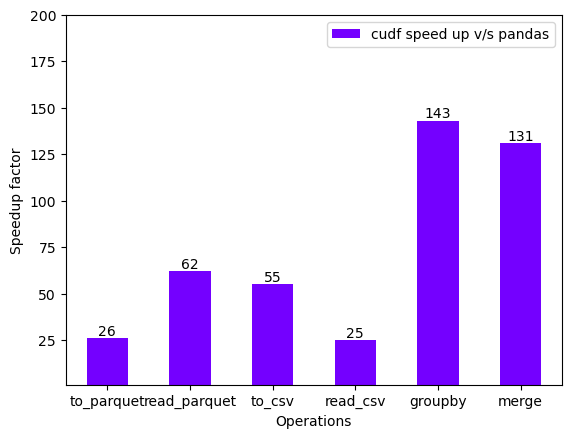

In [30]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,200), rot=0)
ax.set_xlabel("Operations")
ax.set_ylabel("Speedup factor")
ax.bar_label(ax.containers[0])

In [31]:
# Cleaning up used memory for later benchmarks
del pdf
del gdf
del cudf_csv
del pandas_csv
del pandas_pq
del cudf_pq

In [32]:
pd_series = pd.Series(np.random.choice(["123", "56.234", "Walmart", "Costco", "rapids ai"], size=30_000_0000))

In [33]:
gd_series = cudf.from_pandas(pd_series)

In [34]:
pandas_upper = timeit.timeit(lambda : pd_series.str.upper(), number=20)

In [35]:
cudf_upper = timeit.timeit(lambda : gd_series.str.upper(), number=20)

In [36]:
pandas_contains = timeit.timeit(lambda : pd_series.str.contains(r"[0-9][a-z]"), number=20)

In [37]:
cudf_contains = timeit.timeit(lambda : gd_series.str.contains(r"[0-9][a-z]"), number=20)

In [38]:
pandas_isalpha = timeit.timeit(lambda : pd_series.str.isalpha(), number=20)

In [39]:
cudf_isalpha = timeit.timeit(lambda : gd_series.str.isalpha(), number=20)

In [40]:
perf_df = pd.DataFrame(
    {
        "cudf speed up v/s pandas": [pandas_upper/cudf_upper, pandas_contains/cudf_contains, pandas_isalpha/cudf_isalpha],
    },
    index=["upper", "contains", "is_alpha"]
).astype('int')

In [41]:
perf_df

,cudf speed up v/s pandas
upper,1763
contains,1315
is_alpha,5201


## Strings Performance

[Text(0, 0, '1763'), Text(0, 0, '1315'), Text(0, 0, '5201')]

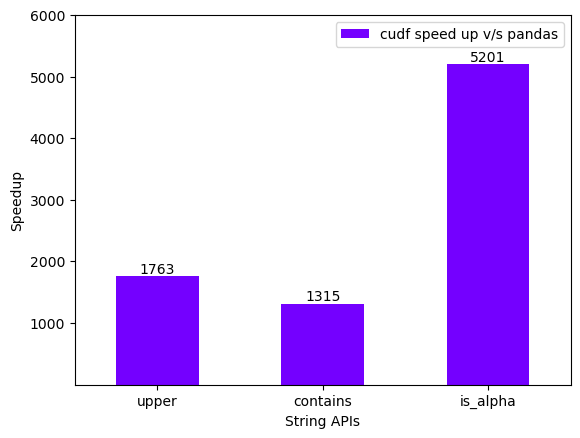

In [42]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,6000), rot=0)
ax.set_xlabel("String APIs")
ax.set_ylabel("Speedup")
ax.bar_label(ax.containers[0])

In [43]:
size = 10_000_000
pdf = pd.DataFrame({
    'age': np.random.randint(0,100,size),
})

In [44]:
def f(row):
    if row['age'] < 18:
        return 0
    elif 18 <= row['age'] < 20:
        return 1
    elif 20 <= row['age'] < 30:
        return 2
    elif 30 <= row['age'] < 40:
        return 3
    elif 40 <= row['age'] < 50:
        return 4
    elif 50 <= row['age'] < 60:
        return 5
    elif 60 <= row['age'] < 70:
        return 6
    else:
        return 7

In [45]:
gdf = cudf.from_pandas(pdf)

In [46]:
pandas_int_udf = timeit.timeit(lambda : pdf.apply(f, axis=1), number=1)

In [47]:
cudf_int_udf = timeit.timeit(lambda : gdf.apply(f, axis=1), number=1)

In [48]:
def str_func(row):
    if row.isupper():
        return 0
    else:
        return 1

In [49]:
pd_series = pd.Series(np.random.choice(["ABC", "abc", "hello world", "AI"], size=10_000_0000), name='strings')

In [50]:
gd_series = cudf.from_pandas(pd_series)

In [51]:
pandas_str_udf = timeit.timeit(lambda : pd_series.apply(str_func), number=1)

In [52]:
cudf_str_udf = timeit.timeit(lambda : gd_series.apply(str_func), number=1)

In [53]:
size = 10_000_0000
pdf = pd.DataFrame()
pdf['key'] = np.random.randint(0,2,size)
pdf['val'] = np.random.randint(0,7,size)


def mult(df):
  df['out'] = df['key'] * df['val'] - 10
  return df


gdf = cudf.from_pandas(pdf)

In [54]:
pandas_udf_groupby = timeit.timeit(lambda : pdf.groupby(['key']).apply(mult), number=1)

/tmp/ipykernel_413/700186240.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pandas_udf_groupby = timeit.timeit(lambda : pdf.groupby(['key']).apply(mult), number=1)


In [55]:
cudf_udf_groupby = timeit.timeit(lambda : gdf.groupby(['key']).apply(mult), number=1)

In [56]:
perf_df = pd.DataFrame(
    {
    "cudf speed up v/s pandas": [pandas_int_udf/cudf_int_udf, 
                                 pandas_str_udf/cudf_str_udf,
                                 pandas_udf_groupby/cudf_udf_groupby],
}, index=["int_udf", 
          "str_udf",
          "groupby_udf"]).astype('int')

In [57]:
perf_df

,cudf speed up v/s pandas
int_udf,60
str_udf,199
groupby_udf,449


## UDF performance (with JIT overhead)

The first UDF runs include JIT compilation overhead, due to which the performance of 1st run and average of next few runs are compared separately.

[Text(0, 0, '60'), Text(0, 0, '199'), Text(0, 0, '449')]

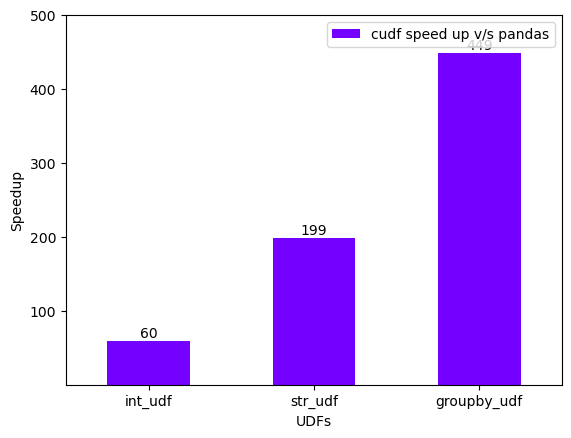

In [58]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,500), rot=0)
ax.set_xlabel("UDFs")
ax.set_ylabel("Speedup")
ax.bar_label(ax.containers[0])

In [62]:
size = 10_000_000
pdf = pd.DataFrame({
    'age': np.random.randint(0,100,size),
})

In [63]:
def f(row):
    if row['age'] < 18:
        return 0
    elif 18 <= row['age'] < 20:
        return 1
    elif 20 <= row['age'] < 30:
        return 2
    elif 30 <= row['age'] < 40:
        return 3
    elif 40 <= row['age'] < 50:
        return 4
    elif 50 <= row['age'] < 60:
        return 5
    elif 60 <= row['age'] < 70:
        return 6
    else:
        return 7

In [64]:
gdf = cudf.from_pandas(pdf)

In [65]:
pandas_int_udf = timeit.timeit(lambda : pdf.apply(f, axis=1), number=10)

In [66]:
cudf_int_udf = timeit.timeit(lambda : gdf.apply(f, axis=1), number=10)

In [67]:
def str_func(row):
    if row.isupper():
        return 0
    else:
        return 1

In [68]:
pd_series = pd.Series(np.random.choice(["ABC", "abc", "hello world", "AI"], size=10_000_0000), name='strings')

In [69]:
gd_series = cudf.from_pandas(pd_series)

In [70]:
pandas_str_udf = timeit.timeit(lambda : pd_series.apply(str_func), number=10)

In [71]:
cudf_str_udf = timeit.timeit(lambda : gd_series.apply(str_func), number=10)

In [72]:
size = 10_000_0000
pdf = pd.DataFrame()
pdf['key'] = np.random.randint(0,2,size)
pdf['val'] = np.random.randint(0,7,size)


def mult(df):
  df['out'] = df['key'] * df['val'] - 10
  return df


gdf = cudf.from_pandas(pdf)

In [73]:
pandas_udf_groupby = timeit.timeit(lambda : pdf.groupby(['key']).apply(mult), number=10)

/tmp/ipykernel_413/1960370463.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pandas_udf_groupby = timeit.timeit(lambda : pdf.groupby(['key']).apply(mult), number=10)
/tmp/ipykernel_413/1960370463.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pandas_udf_groupby = timeit.timeit(lambda :

In [74]:
cudf_udf_groupby = timeit.timeit(lambda : gdf.groupby(['key']).apply(mult), number=10)

In [75]:
perf_df = pd.DataFrame(
    {
    "cudf speed up v/s pandas": [pandas_int_udf/cudf_int_udf, 
                                 pandas_str_udf/cudf_str_udf,
                                 pandas_udf_groupby/cudf_udf_groupby],
}, index=["int_udf", 
          "str_udf",
          "groupby_udf"]).astype('int')

In [76]:
perf_df

,cudf speed up v/s pandas
int_udf,87212
str_udf,2374
groupby_udf,426


## UDF performance (without JIT overhead)

[Text(0, 0, '87212'), Text(0, 0, '2374'), Text(0, 0, '426')]

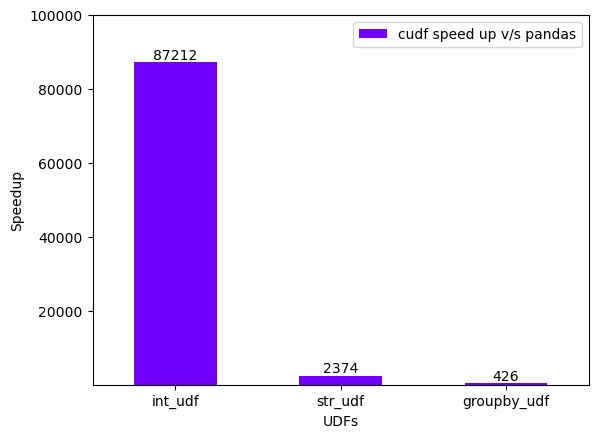

In [77]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,100000), rot=0)
ax.set_xlabel("UDFs")
ax.set_ylabel("Speedup")
ax.bar_label(ax.containers[0])

# System Configuration

## CPU Configuration

In [78]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          80
On-line CPU(s) list:             0-79
Thread(s) per core:              2
Core(s) per socket:              20
Socket(s):                       2
NUMA node(s):                    2
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) Gold 6230 CPU @ 2.10GHz
Stepping:                        7
CPU MHz:                         800.049
CPU max MHz:                     3900.0000
CPU min MHz:                     800.0000
BogoMIPS:                        4200.00
Virtualization:                  VT-x
L1d cache:                       1.3 MiB
L1i cache:                       1.3 MiB
L2 cache:                        40 MiB
L3 cache:                     

## GPU Configuration

In [79]:
!nvidia-smi

Mon Feb  6 17:43:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.04    Driver Version: 525.60.04    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  H100 80GB HBM2e     On   | 00000000:1E:00.0 Off |                    0 |
| N/A   30C    P0    60W / 700W |      0MiB / 81559MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  H100 80GB HBM2e     On   | 00000000:22:00.0 Off |                    0 |
| N/A   